In [3]:
# Import Python Libraries
import numpy as np
import sys
import os
import matplotlib
import matplotlib.pyplot as plt
import math
import seaborn as sns
import h5py
import pandas as pd
import netCDF4
import os
import subprocess
import scipy
import collections as col
import mpmath
import pdb
import copy

## Figures config
plt.style.use('/home/thea/mycode/python/myfig.mplstyle')
myblue = '#244c77ff'
mycyan = '#3f7f93ff'
myred ='#c3553aff'
myorange ='#f4a40bff'

## Config
confdir = os.getcwd()

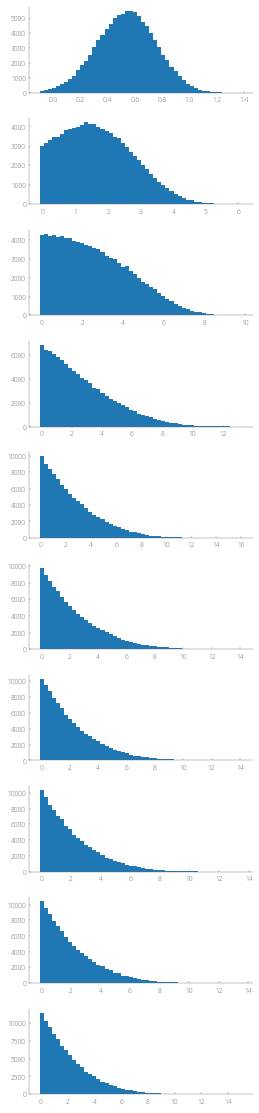

In [65]:
def calcM0(slip,area):
    '''
    in dyne.m
    
    mu S D *nbr subfaults * 10**7 to convert to dyn.cm
    '''
    mu = 2.5*1.e10
    
    # convert area to m2 (slip already in m)
    ssum = (slip[:]*area*1e6).sum()
    
    M0 = ssum * mu * 1.e7
    Mw = (2./3.)*np.log10(M0)-10.7

    return M0, Mw

## Read target
ini_trgt = np.loadtxt(confdir+'/co_slip_rishav.dat', delimiter=',')
trgt = np.array([np.average(ini_trgt[i:i+20,1]) for i in np.arange(0,200,20)] + np.zeros((10,)).tolist())
area=2*50
M0, Mw = calcM0(trgt[:10],area)

## Read AlTar results
h5file =  h5py.File(confdir+'/a2.h5','r')
ss = h5file['ParameterSets']['strikeslip'][()]
ds = h5file['ParameterSets']['dipslip'][()]
samp = np.transpose(np.hstack((ss,ds)))
Np= np.shape(samp)[0]  # number of subfaults
std = [np.std(samp[i,:]) for i in range(Np) ]
moy = np.mean( samp, axis=1 )

## Plot marginal PDFs
fig, ax = plt.subplots(10,1,figsize=(4,20))
for i in range(10):
    ax[i].hist(ss[:,i], bins=50)

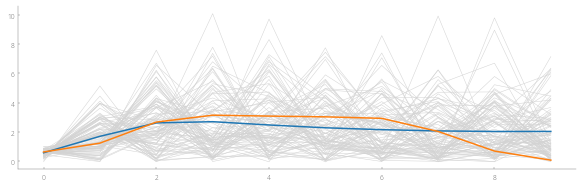

In [5]:
## Plot samples
fig, ax = plt.subplots(1,1,figsize=(10,3))
[plt.plot(ss[i,:], lw=0.5, c='lightgray') for i in range(ss.shape[0]-100,ss.shape[0])]
plt.plot(moy[:10])
plt.plot(trgt[:10])

<AxesSubplot:>

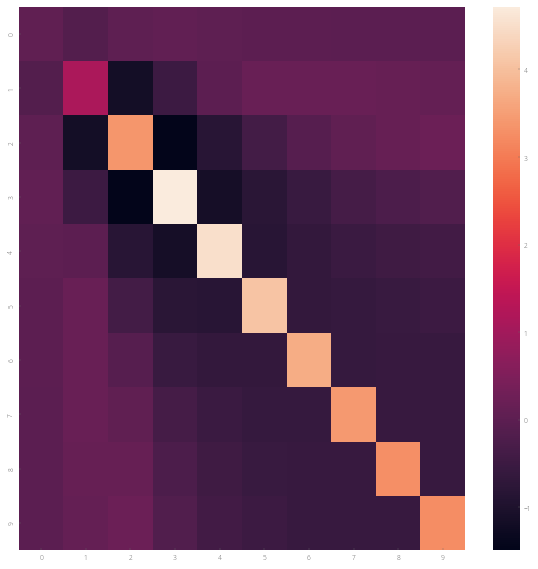

In [6]:
## Plot Covariance
cov = np.cov(ss.T)
fig, ax = plt.subplots(1,1,figsize=(10,10))
sns.heatmap(cov)

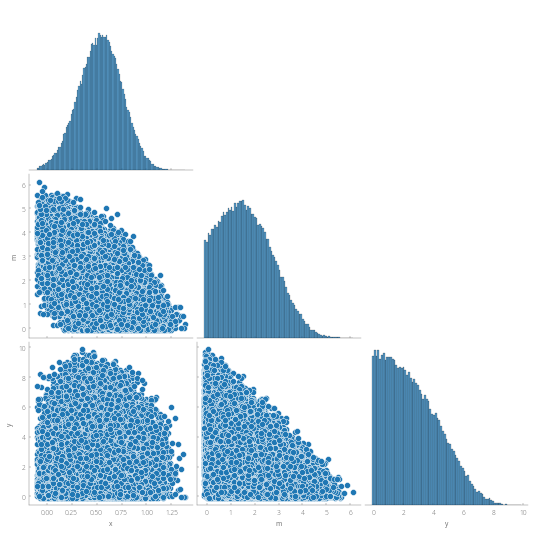

In [7]:
sns.pairplot(pd.DataFrame({"x": ss.T[0], "m": ss.T[1], "y": ss.T[2]}), corner=True)

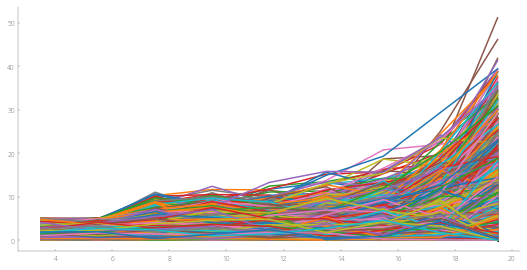

In [143]:
Nsamp = 50000
p = np.empty((10,Nsamp))
L = np.zeros((3,Np//2))
L[2,:] = np.arange(1,20,2)
        
for i in range(10):
    n = np.random.randint(0,ss.shape[0],Nsamp)
    p[i] = ss[n,i]

resamp=[]
plt.figure()
for i in range(Nsamp):
    Mw_samp = calcM0(p[:,i],area)[1]
    if (Mw-0.5<=Mw_samp and Mw_samp<=Mw+0.5):
        ## Semivariogram
        m = np.array([[math.sqrt((L[0,k]-L[0,j])**2+(L[1,k]-L[1,j])**2+(L[2,k]-L[2,j])**2), p[k,i], p[j,i]] 
                                 for k in range(Np//2) for j in range(Np//2) if k>j])
        ii = np.argsort(m[:,0])
        dis = m[ii,0]
        dv = (m[ii,1] - m[ii,2])**2

        bins = np.arange(0., 25, 1)
        inds = np.digitize(dis, bins)

        distance = []
        covariogram = []
        std = []
        for l in range(len(bins)-1):
            uu = np.flatnonzero(inds==l)
            if len(uu)>0:
                distance.append(bins[l] + (bins[l+1] - bins[l])/2.)
                covariogram.append(0.5*np.mean(dv[uu]))
                std.append(np.std(dv[uu]))
        if np.amax(covariogram[0:2])< 5:
            plt.plot(distance, covariogram)
            resamp.append(p[:,i])

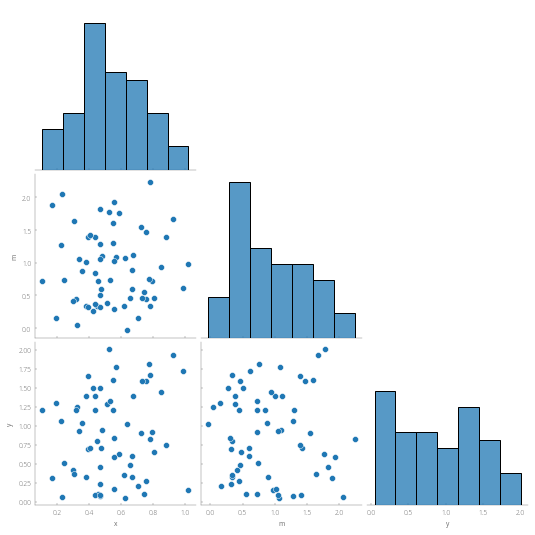

In [137]:
resamp=np.array(resamp)
sns.pairplot(pd.DataFrame({"x": resamp.T[0], "m": resamp.T[1], "y": resamp.T[2]}), corner=True)

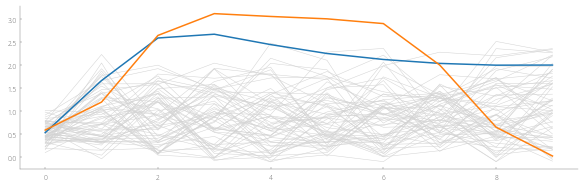

In [138]:
fig, ax = plt.subplots(1,1,figsize=(10,3))
[plt.plot(resamp[i,:], lw=0.5, c='lightgray') for i in range(resamp.shape[0])]
plt.plot(moy[:10])
plt.plot(trgt[:10])


In [139]:
covariogram

[8.284928222327636,
 6.651286922001766,
 10.548166957619316,
 9.507427592843925,
 5.653369515421433,
 8.38500957348333,
 3.3651858121503437,
 1.005138941371813,
 0.05783651542228263]

In [140]:
distance

[3.5, 5.5, 7.5, 9.5, 11.5, 13.5, 15.5, 17.5, 19.5]

In [141]:
bins

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24.])